# Real Time Driver Drowsiness Detection Using Machine Learning and Deep Learning Techniques

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import cv2
import re
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## 1. Data Pre-processing

In [ ]:
# Set root path
root_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Driver Drowsiness Dataset'

#### Preliminary Exploratory Data Analysis (EDA) of the Raw Dataset

Define functions:

In [ ]:
# Function to extract subject ID and frame number from filename
def extract_subject_and_frame(filename, category):
    """Extract subject ID and frame number from filename, standardizing subject ID casing."""
    match = re.match(r"([A-Za-z]+)([0-9]+)", filename)
    if match:
        subject_id = match.group(1)
        frame_number = int(match.group(2))

        # Standardize subject ID casing (convert all to uppercase for consistency)
        if category == "Non Drowsy":
            subject_id = subject_id.upper()

        return subject_id, frame_number
    return None, None

In [ ]:
# Function to explore dataset
def explore_dataset(dataset_path):
    """Perform exploratory data analysis on the dataset."""
    category_counts = {}
    subject_counts = {}
    frame_counts = []
    subject_category = []

    for category in ["Drowsy", "Non Drowsy"]:
        folder = os.path.join(dataset_path, category)
        if os.path.exists(folder):
            images = sorted(os.listdir(folder))
            category_counts[category] = len(images)

            for filename in images:
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    subject_id, frame_number = extract_subject_and_frame(filename, category)
                    if subject_id is not None:
                        if subject_id not in subject_counts:
                            subject_counts[subject_id] = {"Drowsy": 0, "Non Drowsy": 0}
                        subject_counts[subject_id][category] += 1
                        frame_counts.append(frame_number)
                        subject_category.append((subject_id, category))

    print("Category Distribution:")
    for category, count in category_counts.items():
        print(f"{category}: {count} images")

    print("\nNumber of Unique Subjects:", len(subject_counts))
    print("Frame Number Range: Min =", min(frame_counts), "Max =", max(frame_counts))

    return category_counts, subject_counts, frame_counts

EDA on raw dataset:

In [ ]:
# Perform EDA on raw dataset
category_counts, subject_counts, frame_counts = explore_dataset(root_path)

Category Distribution:
Drowsy: 22348 images
Non Drowsy: 19445 images

Number of Unique Subjects: 28
Frame Number Range: Min = 1 Max = 1760


In [ ]:
# Percentage distribution of drowsy vs non-drowsy images
total_images = sum(category_counts.values())
for category, count in category_counts.items():
    percentage = (count / total_images) * 100
    print(f"{category}: {count} images ({percentage:.1f}%)")

Drowsy: 22348 images (53.5%)
Non Drowsy: 19445 images (46.5%)


In [ ]:
# Convert subject counts to a DataFrame for plotting
df_subjects = pd.DataFrame.from_dict(subject_counts, orient='index').reset_index()
df_subjects = df_subjects.rename(columns={"index": "Subject ID"})

df_subjects_percentage = df_subjects.copy()
df_subjects_percentage["Drowsy"] /= (df_subjects_percentage["Drowsy"] + df_subjects_percentage["Non Drowsy"])
df_subjects_percentage["Non Drowsy"] /= (df_subjects_percentage["Drowsy"] + df_subjects_percentage["Non Drowsy"])

# Convert to percentages (0-100%)
df_subjects_percentage["Drowsy"] *= 100
df_subjects_percentage["Non Drowsy"] *= 100

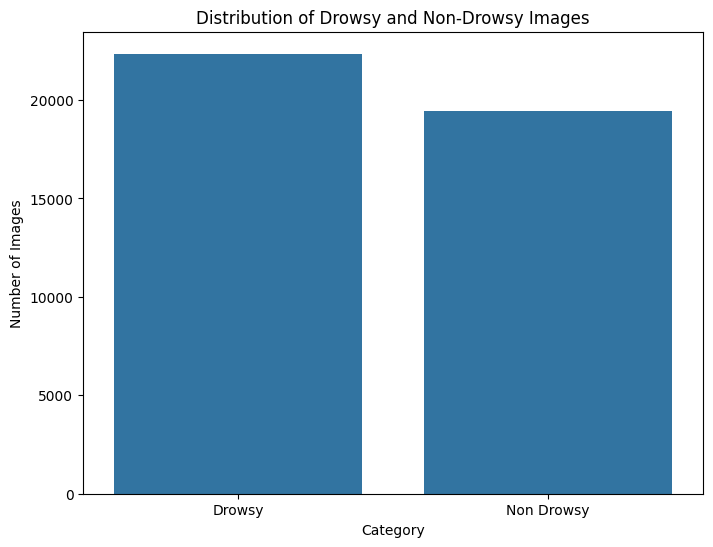

In [ ]:
# Plot category distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title("Distribution of Drowsy and Non-Drowsy Images")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

The countplot above shows that the dataset is slightly imbalanced, with Drowsy images making up 53.5% of the total and Non-Drowsy images comprising the remaining 46.5%.

<ipython-input-32-a2aae83b073b>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


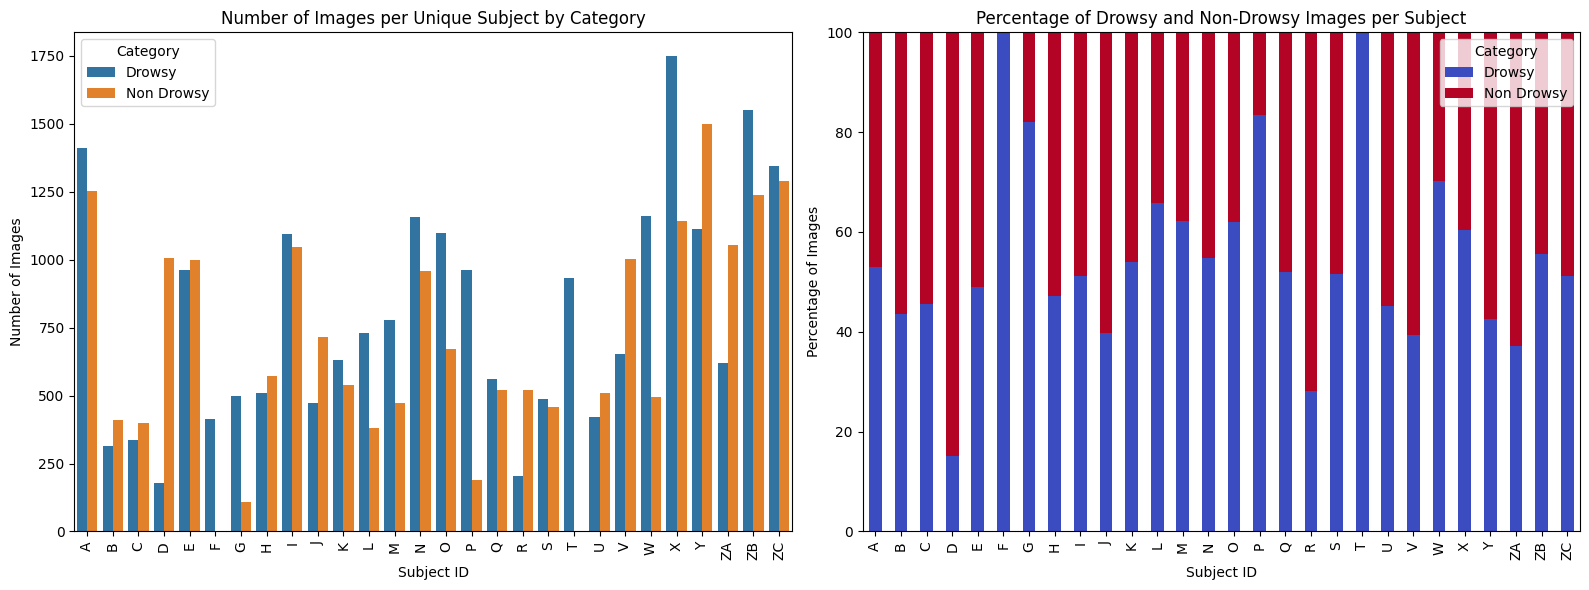

In [ ]:
# Create subplots for absolute and percentage distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute image count per subject
sns.barplot(ax=axes[0], data=df_subjects.melt(id_vars=["Subject ID"], value_vars=["Drowsy", "Non Drowsy"], var_name="Category", value_name="Count"),
            x="Subject ID", y="Count", hue="Category", dodge=True)
axes[0].set_xlabel("Subject ID")
axes[0].set_ylabel("Number of Images")
axes[0].set_title("Number of Images per Unique Subject by Category")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].legend(title="Category")

# Stacked bar plot for percentage distribution
df_subjects_percentage.set_index("Subject ID").plot(kind='bar', stacked=True, ax=axes[1], colormap="coolwarm")
axes[1].set_xlabel("Subject ID")
axes[1].set_ylabel("Percentage of Images")
axes[1].set_title("Percentage of Drowsy and Non-Drowsy Images per Subject")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].legend(title="Category")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

From the bar plots above, it can be observed that the number of images varies across unique subjects, indicating an uneven sample distribution. Additionally, the class distribution is not consistent among subjects—some are heavily skewed toward either the drowsy or non-drowsy class, while only a few exhibit a balanced representation. Notably, Subjects F and T have zero non-drowsy images, introducing a significant bias that may impact the model’s ability to generalize across different individuals.



#### Addressing the Imbalance in Image Distribution per Subject

The following strategies are taken to balance the dataset:

1. Remove subjects that have only one category (either only Drowsy or only Non-Drowsy)
2. Implement Smart Downsampling to balance subjects while maintaining sequence integrity.
  *   Instead of randomly dropping frames, select evenly spaced frames.
  *   This ensures that the temporal nature of sequences is preserved for LSTM.



In [8]:
# Define path for processed images
processed_images_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Driver Drowsiness Dataset_Filtered'

In [ ]:
# Define max target count for downsampling
target_count = 240
print(f"Target images per Subject for downsampling: {target_count}")

Target images per Subject for downsampling: 240


In [ ]:
# List of subjects missing one category (from EDA above)
unbalanced_subjects = ['F', 'T']

Define functions:

In [ ]:
# Function to extract only subject ID from filename
def extract_subject_id(filename):
    match = re.match(r"([A-Za-z]+)([0-9]+)", filename)
    if match:
        return match.group(1)
    return None

In [ ]:
# Function to move only balanced subjects to a new folder
def move_balanced_subjects(dataset_path, processed_path, unbalanced_subjects):
    """Moves only balanced subjects to a new folder instead of copying the entire dataset."""
    if os.path.exists(processed_path):
        shutil.rmtree(processed_path)  # Remove if already exists
    os.makedirs(processed_path)

    for category in ["Drowsy", "Non Drowsy"]:
        src_folder = os.path.join(dataset_path, category)
        dest_folder = os.path.join(processed_path, category)

        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        if os.path.exists(src_folder):
            for filename in os.listdir(src_folder):
                subject_id = extract_subject_id(filename)
                if subject_id and subject_id not in unbalanced_subjects:
                    shutil.move(os.path.join(src_folder, filename), os.path.join(dest_folder, filename))

    print(f"Balanced subjects moved successfully to {processed_path}")

In [ ]:
# Function to apply smart downsampling
def smart_downsample(images, target_count):
    """Downsample while preserving sequence integrity by selecting evenly spaced frames."""
    if len(images) <= target_count:
        return images  # No need to downsample

    indices = np.linspace(0, len(images) - 1, target_count, dtype=int)
    return [images[i] for i in indices]

In [ ]:
# Function to apply downsampling on remaining subjects
def apply_downsampling(dataset_path, target_count):
    """Applies smart downsampling to remaining subjects."""
    for category in ["Drowsy", "Non Drowsy"]:
        folder = os.path.join(dataset_path, category)
        if os.path.exists(folder):
            subjects_images = {}

            # Group images by subject
            for filename in sorted(os.listdir(folder)):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    subject_id = extract_subject_id(filename)
                    if subject_id:
                        if subject_id not in subjects_images:
                            subjects_images[subject_id] = []
                        subjects_images[subject_id].append(filename)

            # Apply downsampling per subject
            for subject_id, images in subjects_images.items():
                if len(images) > target_count:
                    downsampled_images = smart_downsample(images, target_count)

                    # Remove extra images
                    for filename in images:
                        if filename not in downsampled_images:
                            os.remove(os.path.join(folder, filename))

    print(f"Applied smart downsampling to {dataset_path} with target count {target_count}")

Pre-process the dataset:

In [ ]:
# Move subjects from original dataset
move_balanced_subjects(root_path, processed_images_path, unbalanced_subjects)

Balanced subjects moved successfully to /content/drive/MyDrive/Colab Notebooks/Capstone Project/Driver Drowsiness Dataset_Filtered


In [ ]:
# Apply smart downsampling to the remaining images
apply_downsampling(processed_images_path, target_count)

Applied smart downsampling to /content/drive/MyDrive/Colab Notebooks/Capstone Project/Driver Drowsiness Dataset_Filtered with target count 240


EDA on processed dataset:

In [ ]:
# Perform EDA on dataset
category_counts, subject_counts, frame_counts = explore_dataset(processed_images_path)

Category Distribution:
Drowsy: 6143 images
Non Drowsy: 6059 images

Number of Unique Subjects: 26
Frame Number Range: Min = 1 Max = 1760


In [ ]:
# Percentage distribution of drowsy vs non-drowsy images
total_images = sum(category_counts.values())
for category, count in category_counts.items():
    percentage = (count / total_images) * 100
    print(f"{category}: {count} images ({percentage:.1f}%)")

Drowsy: 6143 images (50.3%)
Non Drowsy: 6059 images (49.7%)


In [ ]:
# Convert subject counts to a DataFrame for plotting
df_subjects = pd.DataFrame.from_dict(subject_counts, orient='index').reset_index()
df_subjects = df_subjects.rename(columns={"index": "Subject ID"})

df_subjects_percentage = df_subjects.copy()
df_subjects_percentage["Drowsy"] /= (df_subjects_percentage["Drowsy"] + df_subjects_percentage["Non Drowsy"])
df_subjects_percentage["Non Drowsy"] /= (df_subjects_percentage["Drowsy"] + df_subjects_percentage["Non Drowsy"])

# Convert to percentages (0-100%)
df_subjects_percentage["Drowsy"] *= 100
df_subjects_percentage["Non Drowsy"] *= 100

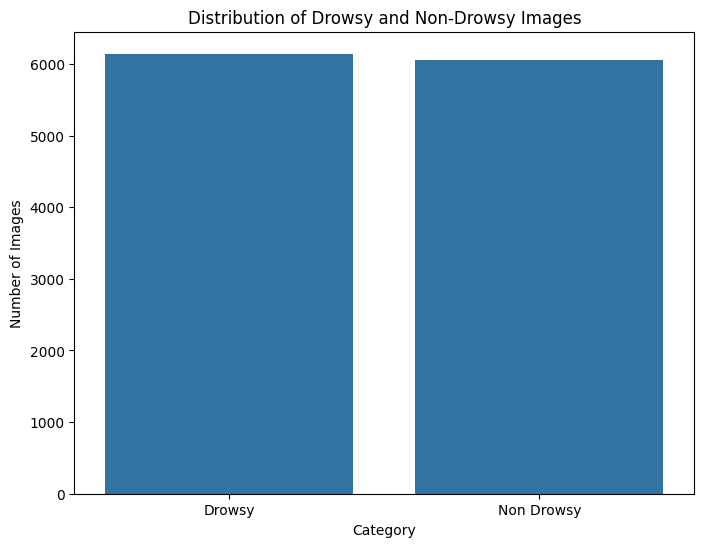

In [ ]:
# Plot category distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title("Distribution of Drowsy and Non-Drowsy Images")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

The countplot above shows that the dataset was reduced to 6,143 drowsy images (50.3%) and 6,059 non-drowsy images (49.7%), achieving a nearly balanced class distribution after pre-processing.

<ipython-input-27-20ee17e66bc8>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


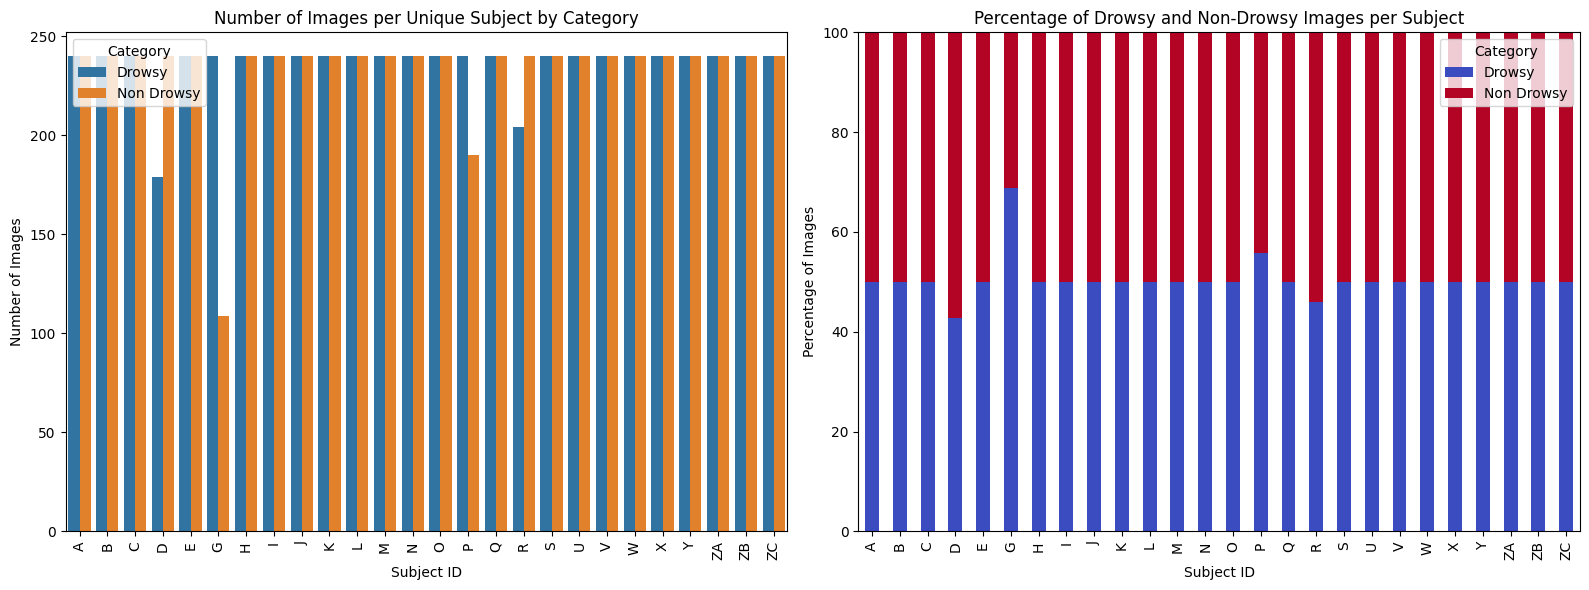

In [ ]:
# Create subplots for absolute and percentage distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute image count per subject
sns.barplot(ax=axes[0], data=df_subjects.melt(id_vars=["Subject ID"], value_vars=["Drowsy", "Non Drowsy"], var_name="Category", value_name="Count"),
            x="Subject ID", y="Count", hue="Category", dodge=True)
axes[0].set_xlabel("Subject ID")
axes[0].set_ylabel("Number of Images")
axes[0].set_title("Number of Images per Unique Subject by Category")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].legend(title="Category")

# Stacked bar plot for percentage distribution
df_subjects_percentage.set_index("Subject ID").plot(kind='bar', stacked=True, ax=axes[1], colormap="coolwarm")
axes[1].set_xlabel("Subject ID")
axes[1].set_ylabel("Percentage of Images")
axes[1].set_title("Percentage of Drowsy and Non-Drowsy Images per Subject")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].legend(title="Category")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

As the maximum number of images per Subject is set to 240 images, the distribution has become more consistent across subjects, with most now having a relatively equal number of drowsy and non-drowsy samples—addressing the imbalance issues present in the raw dataset.

## 2. Facial Features Extraction

In [1]:
# Import libraries
!pip install mediapipe
import mediapipe as mp
from google.colab.patches import cv2_imshow

In [13]:
# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

Define functions:

In [3]:
# Define landmark indices for eyes and mouth
LEFT_EYE_IDX = [33, 160, 158, 133, 153, 144]
RIGHT_EYE_IDX = [263, 387, 385, 362, 373, 380]
MOUTH_IDX = [61, 291, 78, 308, 13, 14, 17, 18, 81, 82, 311, 312]

In [4]:
# Function to calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    """Compute the eye aspect ratio (EAR)."""
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

# Function to calculate mouth aspect ratio (MAR)
def mouth_aspect_ratio(mouth):
    """Compute the mouth aspect ratio (MAR)."""
    A = np.linalg.norm(mouth[3] - mouth[9])
    B = np.linalg.norm(mouth[2] - mouth[10])
    C = np.linalg.norm(mouth[4] - mouth[8])
    D = np.linalg.norm(mouth[0] - mouth[6])
    return (A + B + C) / (3.0 * D)

# Function to compute Mouth-Eye Ratio (MER)
def mouth_eye_ratio(mar, ear):
    """Compute the Mouth-Eye Ratio (MER)."""
    return mar / ear if ear > 0 else 0

# Function to calculate pupil to eye center distance
def pupil_eye_center_distance(eye):
    """Compute the distance from the pupil (eye center) to the average eye landmark center."""
    eye_center = np.mean(eye, axis=0)  # Average position of eye landmarks
    pupil = eye[2]  # Approximate pupil position using middle landmark
    return np.linalg.norm(pupil - eye_center)

In [5]:
# Function to extract facial features using Mediapipe
def extract_facial_features(img):
    """Extract EAR, MAR, MER, and pupil-eye center distance from an image using Mediapipe."""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Mediapipe
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None  # No face detected

    landmarks = results.multi_face_landmarks[0].landmark
    h, w, _ = img.shape

    # Extract eye and mouth landmarks
    left_eye = np.array([[landmarks[i].x * w, landmarks[i].y * h] for i in LEFT_EYE_IDX])
    right_eye = np.array([[landmarks[i].x * w, landmarks[i].y * h] for i in RIGHT_EYE_IDX])
    mouth = np.array([[landmarks[i].x * w, landmarks[i].y * h] for i in MOUTH_IDX])

    # Compute facial metrics
    ear_left = eye_aspect_ratio(left_eye)
    ear_right = eye_aspect_ratio(right_eye)
    mean_ear = (ear_left + ear_right) / 2

    mar = mouth_aspect_ratio(mouth)
    mer = mouth_eye_ratio(mar, (ear_left + ear_right) / 2.0)

    pupil_left = pupil_eye_center_distance(left_eye)
    pupil_right = pupil_eye_center_distance(right_eye)
    mean_pupil_dist = (pupil_left + pupil_right) / 2

    return [mean_ear, mar, mer, mean_pupil_dist]

In [6]:
# Function to analyze processed dataset
def analyze_processed_dataset(dataset_path):
    """Analyzes the processed dataset and extracts facial features using Mediapipe."""
    features = []

    for category in ["Drowsy", "Non Drowsy"]:
        folder = os.path.join(dataset_path, category)
        if os.path.exists(folder):
            images = sorted(os.listdir(folder))

            for filename in images:
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    img_path = os.path.join(folder, filename)
                    img = cv2.imread(img_path)

                    facial_features = extract_facial_features(img)

                    if facial_features is not None:
                        subject_id = filename.split("_")[0]  # Extract Subject ID from filename
                        features.append([subject_id, category] + facial_features)

    df_features = pd.DataFrame(features, columns=["Subject ID", "Category", "EAR_mean", "MAR", "MER", "Pupil_Dist_mean"])
    return df_features

Extract facial features:

In [ ]:
# Perform feature extraction on the processed dataset
df_features = analyze_processed_dataset(processed_images_path)

# Save extracted features
df_features.to_csv("facial_features.csv", index=False)
print("Facial feature extraction complete! Features saved to 'facial_features.csv'.")

Facial feature extraction complete! Features saved to 'facial_features.csv'.


Visualise facial landmarks:

In [11]:
# Load a sample image
sample_image_path = processed_images_path + '/Drowsy/C0010.png'
img = cv2.imread(sample_image_path)

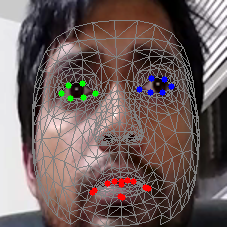

In [14]:
# Plot facial landmarks
if img is None:
    print("Error: Could not load image. Check the file path.")
else:
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process image with MediaPipe FaceMesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(img_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # Get image dimensions
                h, w, _ = img.shape

                # Draw the full face mesh
                mp_drawing.draw_landmarks(
                    image=img,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style()
                )

                # Draw landmarks
                for idx_list, color, label in zip(
                    [LEFT_EYE_IDX, RIGHT_EYE_IDX, MOUTH_IDX],
                    [(0, 255, 0), (255, 0, 0), (0, 0, 255)],  # Green, Blue, Red
                    ["Left Eye", "Right Eye", "Mouth"]
                ):
                    for idx in idx_list:
                        x, y = int(face_landmarks.landmark[idx].x * w), int(face_landmarks.landmark[idx].y * h)
                        cv2.circle(img, (x, y), 3, color, -1)

        # Display image
        cv2_imshow(img)

# 3. Prepare Sequences of Images for CNN + LSTM

In [ ]:
# Define path for processed images
processed_images_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Driver Drowsiness Dataset_Filtered'

In [ ]:
# Define path to save sequences
sequences_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Sequences'

# Ensure output directory exists
os.makedirs(sequences_path, exist_ok=True)

In [ ]:
# Define target image size
img_size = (96, 96)

In [ ]:
# Define number of frames per sequence
sequence_length = 30

Define functions:

In [ ]:
# Function to extract subject ID and frame number from filename
def extract_subject_and_frame(filename, category):
    """Extract subject ID and frame number from filename, standardizing subject ID casing."""
    match = re.match(r"([A-Za-z]+)([0-9]+)", filename)
    if match:
        subject_id = match.group(1)
        frame_number = int(match.group(2))

        # Standardize subject ID casing (convert all to uppercase for consistency)
        if category == "Non Drowsy":
            subject_id = subject_id.upper()
        return subject_id, frame_number
    return None, None

In [ ]:
# Function to load images from the pre-processed images folder
def load_images_from_folder(folder, label):
    """Load grayscale images, extract subject ID & frame number, and resize."""
    subjects = {}

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            subject_id, frame_number = extract_subject_and_frame(filename, label)
            if subject_id is not None:
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                img = cv2.resize(img, img_size)  # Resize to smaller size
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
                img = img_to_array(img) / 255.0  # Normalize

                # Group images by subject ID
                if subject_id not in subjects:
                    subjects[subject_id] = []
                subjects[subject_id].append((frame_number, img))

    return subjects

In [ ]:
# Function to create sequences
def create_sequences(subjects, label):
    sequences, labels, subject_ids = [], [], []
    for subject_id, frames in subjects.items():
        frames.sort()
        images = [img for _, img in frames]
        for i in range(len(images) - sequence_length + 1):
            X_seq = np.array(images[i:i + sequence_length])
            sequences.append(X_seq)
            labels.append(label)
            subject_ids.append(subject_id)
    return sequences, labels, subject_ids

Prepare sequences for CNN+LSTM:

In [ ]:
# Load images from both folders
drowsy_subjects = load_images_from_folder(os.path.join(processed_images_path, "Drowsy"), 1)
non_drowsy_subjects = load_images_from_folder(os.path.join(processed_images_path, "Non Drowsy"), 0)

In [ ]:
# Prepare sequences for both classes
X_drowsy, y_drowsy, s_drowsy = create_sequences(drowsy_subjects, 1)
X_non_drowsy, y_non_drowsy, s_non_drowsy = create_sequences(non_drowsy_subjects, 0)

In [ ]:
# Ensure the no. of sequences of images and their categories have equal lengths
assert len(X_drowsy) == len(y_drowsy), f"Mismatch in drowsy sequences: {len(X_drowsy)} X vs {len(y_drowsy)} y"
assert len(X_non_drowsy) == len(y_non_drowsy), f"Mismatch in non-drowsy sequences: {len(X_non_drowsy)} X vs {len(y_non_drowsy)} y"

In [ ]:
# Combine and shuffle
X_all = np.array(X_drowsy + X_non_drowsy)
y_all = np.array(y_drowsy + y_non_drowsy)
s_all = np.array(s_drowsy + s_non_drowsy)

In [ ]:
# Encode labels
y_all_bin = y_all.astype(np.float32)

Save train & test dataset to be loaded for training later:

In [ ]:
# Subject-wise Train-Test Split
unique_subjects = np.unique(s_all)
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)

train_indices = [i for i, sid in enumerate(s_all) if sid in train_subjects]
test_indices = [i for i, sid in enumerate(s_all) if sid in test_subjects]

X_train_subject, X_test_subject = X_all[train_indices], X_all[test_indices]
y_train_subject, y_test_subject = y_all_bin[train_indices], y_all_bin[test_indices]

In [ ]:
# Save subject-wise split
np.savez_compressed(os.path.join(sequences_path, "subject_split.npz"),
                    X_train=X_train_subject, X_test=X_test_subject,
                    y_train=y_train_subject, y_test=y_test_subject)

In [ ]:
# Random Train-Test Split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_all, y_all_bin, test_size=0.2, random_state=42)

In [ ]:
# Save random split
np.savez_compressed(os.path.join(sequences_path, "random_split.npz"),
                    X_train=X_train_rand, X_test=X_test_rand,
                    y_train=y_train_rand, y_test=y_test_rand)